In [1]:
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing, remove_small_objects, dilation, erosion, disk
from aicssegmentation.core.pre_processing_utils import  intensity_normalization, edge_preserving_smoothing_3d
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
import matplotlib.pyplot as plt
from itkwidgets import view   
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]
from aicssegmentation.core.MO_threshold import MO

# dots
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

# lamp1
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball  
import warnings
warnings.filterwarnings('ignore')

#shell
from aicssegmentation.core.utils import get_middle_frame, hole_filling, get_3dseed_from_mid_frame
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d

from skimage import filters as skfilters
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from skimage import filters as skfilters

In [2]:
h2b = AICSImage("//allen/aics/assay-dev/users/Frick/PythonProjects/Assessment/Segmentation_Testing/Sparkle_and_blob_project/H2B_sparkle_blob/h2b_segmentation_saves/3500002669_100X_20190118_1-alignV2-Scene-67-P68-C09_raw.tif").data.squeeze()
# h2b = AICSImage("//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/h2b/deconvolution/tiff-og/3500002670_100X_20190118_1-Scene-01-P1-C02.ome.tiff").data.squeeze()
h2b_original = h2b.copy() # shape should be (x,y,z)
h2b = h2b.max(axis=0) # shape should be (x,y)

In [3]:
print(h2b_original.shape)
print(h2b.shape)

(65, 600, 900)
(600, 900)


In [4]:
# # h2b_original.shape = (4, 65, 624, 924) but want it to be (65, 624,924)


# h2b_og_resize = h2b_original[0, :, :,:]
# h2b_resize = h2b[0, :, :]


# print(h2b_og_resize.shape)
# print(h2b_resize.shape)

In [19]:
h2b.shape

(600, 900)

In [5]:
# Compute high-end Otsu threshold
thresh = [1.0*t for t in skfilters.threshold_multiotsu(h2b)][1]
# Blur segmentation mask to estimate regions with high intensity signal
bkg = skfilters.gaussian((h2b>thresh).astype(np.float32), 50, preserve_range=True)
# Normalize to [0,1]
vmin, vmax = np.percentile(bkg, [1,99])
bkg = np.clip(bkg, vmin, vmax)
bkg = (bkg-vmin)/(vmax-vmin)

# Compute correction. 
correct = (h2b-0.5*bkg*h2b)

print(correct.shape)

(600, 900)


In [18]:
thresh

1556.0

In [6]:
# correct_resize = correct[0, :, :]
# print(correct_resize.shape)

In [7]:
# Apply the correction to the original 3D image (use this as input for segmentation workflow)
h2b_original = h2b_original-0.5*np.expand_dims(bkg,0)*h2b_original

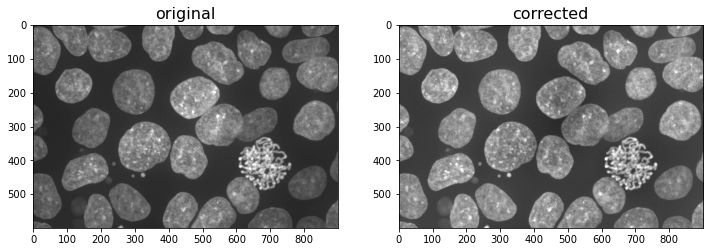

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))
axs[0].imshow(h2b, cmap="gray", vmin=100, vmax=3000)
axs[0].set_title("original", fontsize=16)
axs[1].imshow(correct, cmap="gray", vmin=100, vmax=2000)
axs[1].set_title("corrected", fontsize=16)
plt.show()

In [9]:
# # want it to be (x,y,z)
# print(h2b_original.shape)

# h2b_resize = h2b[0, :, :]
# correct_resize = correct[0, :, :]
# print(h2b_resize.shape)
# print(correct_resize.shape)

In [10]:
# filename = "//allen/aics/assay-dev/users/Frick/PythonProjects/Assessment/Segmentation_Testing/Sparkle_and_blob_project/H2B_sparkle_blob/h2b_segmentation_saves/3500002669_100X_20190118_1-alignV2-Scene-67-P68-C09_raw.tif"
# reader = AICSImage(filename) 
# IMG = reader.data.astype(np.float32)

# print(IMG.shape)

In [11]:
# N_CHANNELS = h2b_original.shape[1] # N_CHANNELS = IMG.shape[1] 
# MID_SLICE = np.int(0.5*IMG.shape[2])

# fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
# if N_CHANNELS==1:
#     ax.axis('off')
#     ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
# else:
#     for channel in range(N_CHANNELS):
#         ax[channel].axis('off')
#         ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [12]:
# #####################
# structure_channel = 0

# #####################

# struct_img0 = IMG[0,structure_channel,:,:,:].copy()

# view(single_fluorescent_view(struct_img0))

<h1> Experimental <h1>

In [13]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [1,5.5] # current: [1,5.5]
gaussian_smoothing_sigma = 1
################################
# intensity normalization
struct_img = intensity_normalization(h2b_original, scaling_param=intensity_scaling_param)


# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

view(single_fluorescent_view(structure_img_smooth))


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [14]:
# from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
# suggest_normalization_param(struct_img0)

In [15]:
# # Mask Object Thresholding
# bw1, object_for_debug = MO(structure_img_smooth, global_thresh_method='ave', object_minArea=700, return_object=True, 
#                           local_adjust=1.95)

In [16]:
# Otsu thresholding
# increase th, thinner/less segmentation. decrease th, chunkier/more segmentation.
th = 2.90* threshold_otsu(structure_img_smooth) # original at 1.4 # current: 2.90
overall_shape = dilation(
    remove_small_objects(structure_img_smooth > th, min_size=1, connectivity=1, in_place=False), #min_size = 10
    ball(1)
)
fixed_shape = erosion(
    hole_filling(overall_shape, hole_min=0, hole_max=5, fill_2d=True), #, hole_min= 0 hole_max = 5
    ball(1)
)

# view(segmentation_quick_view(fixed_shape))

In [17]:
# bw_merge = np.logical_or(bw1, fixed_shape)

In [46]:
################################
## PARAMETERS for this step ##
minArea = 5 # original: 5
################################

seg = remove_small_objects(fixed_shape>0, min_size=minArea, connectivity=1) # bw>0 # connectivity=1 #in_place=False

In [47]:
out=fixed_shape.astype(np.uint8)
out[out>0]=255

imsave("blobseg-sc67-p68-c09-EXP2.tiff", out) 